# Rede neural 65622 - Adaptações dos parâmetros
Melhor desempenho considerando o critério de maior cos_sim e menor loss 

In [1]:
# Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", 300)

D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(Net, self).__init__()
        self.num_layers = num_layers

        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size[0])])
        for i in range(0, self.num_layers-2):
            self.linears.extend([nn.Linear(layers_size[i], layers_size[i+1])])              
        self.linears.append(nn.Linear(layers_size[-1], output_size))

#     def forward(self, x):
#         for layer in self.linears[0:-1]:                   
#             x = torch.tanh(layer(x))
#         x = self.linears[-1](x)
#         return(x)

## Aplicar função de ativação na última camada tbm
### Tentar mudar pra sigmoide se deixar a normalização de 0,1
    def forward(self, x):
        for layer in self.linears:                   
            x = torch.tanh(layer(x))
        return(x)

In [3]:
testes = pd.read_csv("Loop_Testes_Regressao2.csv")
rede = testes.iloc[np.where(testes["index"]==65622)]
rede

,index,net_param,ncamadas,n_features,features_col,features_name,random_state,data_train,data_train_resample,test_loss,test_cos_sim,net
15622,65622.0,<bound method Module.parameters of Net(\r\n (...,6,18,[ 1 15 41 49 52 58 86 89 94 97 99 1...,"['AgeGroup', 'Analgesic', 'Diabetesmellitus', ...",77,124,280,0.04118,0.873746,net_65622


In [4]:
print(rede.iloc[0,1])

<bound method Module.parameters of Net(
  (linears): ModuleList(
    (0): Linear(in_features=18, out_features=12, bias=True)
    (1): Linear(in_features=12, out_features=9, bias=True)
    (2): Linear(in_features=9, out_features=6, bias=True)
    (3): Linear(in_features=6, out_features=3, bias=True)
    (4): Linear(in_features=3, out_features=1, bias=True)
    (5): Linear(in_features=1, out_features=1, bias=True)
  )
)>


Numero de features: 18
Colunas:  [0, 15, 41, 49, 52, 58, 86, 89, 94, 97, 99, 111, 117, 123, 135, 152, 167, 173]
Features:  ['Age', 'Analgesic', 'Diabetesmellitus', 'Hblocker', 'Hypercholesterolemia', 'Meglitinide', 'Epilepsy', 'Fatty liver', 'Hiatus hernia', 'Inflammation of the tibial nerve', 'Kidney failure', 'Sickle cell anemia', 'Varicose veins of the legs', 'Depression', 'Vasovagal syncope', 'Hypothyroidism_total', 'Internal fixation in the leg', 'PaceMaker']
Random State: 77
Histogramas dos dados de treino


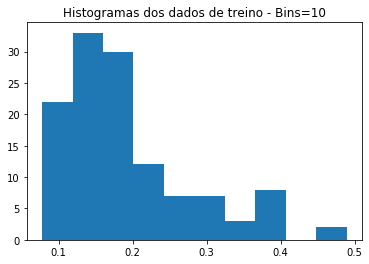

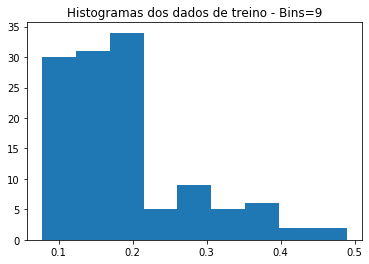

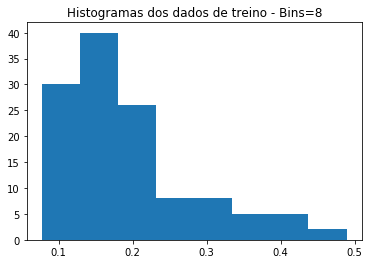

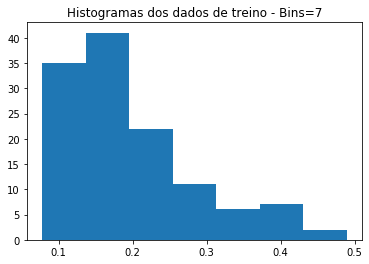

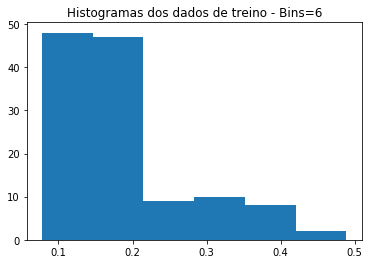

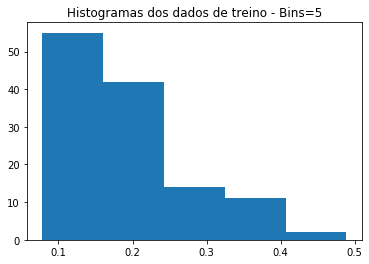

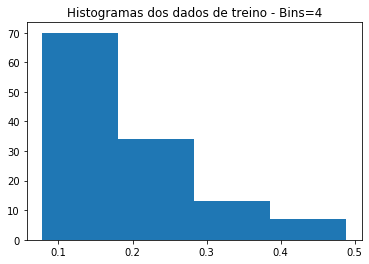

Data train: 124
Data train resample: 280
Histograma dos dados de treino com Resample SMOTE


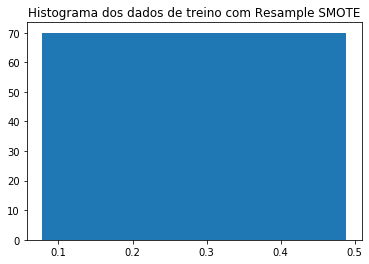

Number of layers: 6
Inicial size layer: 12
Layers sizes: [12, 9, 6, 3, 1]


In [5]:
data = pd.read_pickle("data_closed_rigid_o")
pf50 = data["PF50_closed_rigid"].values

# Sortear quais caracteristicas usar
n_features = rede.iloc[0,3]
print('Numero de features: %d' % (n_features))
## Trocar AgeGroup(1) por Age(0)
columns =   [0, 15, 41, 49, 52, 58, 86, 89, 94, 97, 99, 111, 117, 123, 135, 152, 167, 173]
print('Colunas: ',columns)

features = data.iloc[:,columns]
features_names = features.columns
print('Features: ',list(features_names))
X = features.values
y = pf50.reshape(len(pf50), 1)

# Separando o dataset em treino e teste
### Separar validação tbm (treino 60, teste 30, validação 10)
random_state = rede.iloc[0,6]
print('Random State: %d' % (random_state))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

# Histograma dos dados de treino
print("Histogramas dos dados de treino")
for nbins in range(10,1,-1):
    n, bins, patches = plt.hist(y_train, nbins)
    plt.title("Histogramas dos dados de treino - Bins="+str(nbins))
    plt.show()
    if np.min(n)>3:
        break
        
# Indica qual o bin correspondente para cada dado
indices = np.digitize(y_train, bins)

# Arrumar o caso do último valor que não é incluído no último bin
indices[indices>nbins]=nbins
indices = indices.reshape(len(indices),)

# SMOTE - Data Augmentation
data_train = np.hstack([X_train, y_train])
print('Data train: %d' % (data_train.shape[0]))
sm = SMOTE(k_neighbors=np.int(n.min()-1), random_state=42)
data_train_res, indices_res = sm.fit_resample(data_train, indices)
print('Data train resample: %d' % (data_train_res.shape[0]))

# Histograma dos dados de treino resample
print("Histograma dos dados de treino com Resample SMOTE")
n_res, bins_res, patches_res = plt.hist(data_train_res[:,-1], nbins)
plt.title("Histograma dos dados de treino com Resample SMOTE")
plt.show()

# Declarando o dado resample como dado de treino
X_train = data_train_res[:,0:-1]
y_train = data_train_res[:,-1].reshape(data_train_res.shape[0],1)

# Ajustando o escalamento ao dado de TREINAMENTO (fit) e transformando o dado de treinamento
## Normalização de -1 a 1 --> parece que piorou
scaler_x = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler_x.fit_transform(X_train)

scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train)

torch.manual_seed(1234)

num_layers = rede.iloc[0,2]
print('Number of layers: %d' % (num_layers))
layer_init_size = 12
print('Inicial size layer: %d' % (layer_init_size))
layers_size = np.linspace(layer_init_size, 1, num_layers-1, dtype=int)
print('Layers sizes:', list(layers_size))

net = Net(input_size=X.shape[1], num_layers=num_layers, layers_size=layers_size , output_size=1)


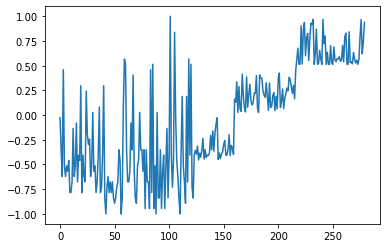

In [6]:
plt.figure()
plt.plot(y_train_scaled)
plt.show()

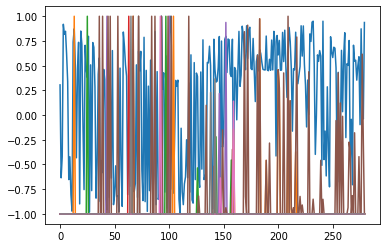

In [7]:
plt.figure()
plt.plot(X_train_scaled)
plt.show()

In [8]:
# Choose optmizer and loss function
criterion = nn.MSELoss()

## Diminuir o lr = learning rate de 0.05 para 0.01
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

# Treinamento utilizando o dado de treino transformado
## Aumentar o número de epochs de 5000 para 100000
epochs = 100000
lossr = np.zeros(epochs)

for epoch in range(epochs):
    inputs = torch.autograd.Variable(torch.Tensor(X_train_scaled.astype(np.float32)).float())
    targets = torch.autograd.Variable(torch.Tensor(y_train_scaled.astype(np.float32)).float())

    optimizer.zero_grad()
    out = net(inputs)
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()

    lossr[epoch] = loss.item()
    
    ### Incluir validação, sem optimizer, loss backward etc
    ### Comparar valores de loss e gravar a melhor rede com o menor loss
    ### Pode tentar incluir um critério de parada se depois de 1000 epochs não gravar nenhuma rede
    ### Procurar interface gráfica simultânea para plotar loss de treino e validação

    if epoch == 0 or (epoch + 1) % 10 == 0:
        print('Epoch %d Loss: %.4f' % (epoch + 1, loss.item()))


Epoch 1 Loss: 0.7738
Epoch 10 Loss: 0.4293
Epoch 20 Loss: 0.3579
Epoch 30 Loss: 0.2945
Epoch 40 Loss: 0.3032
Epoch 50 Loss: 0.2940
Epoch 60 Loss: 0.2943
Epoch 70 Loss: 0.2936
Epoch 80 Loss: 0.2932
Epoch 90 Loss: 0.2930
Epoch 100 Loss: 0.2928
Epoch 110 Loss: 0.2925
Epoch 120 Loss: 0.2922
Epoch 130 Loss: 0.2919
Epoch 140 Loss: 0.2915
Epoch 150 Loss: 0.2911
Epoch 160 Loss: 0.2906
Epoch 170 Loss: 0.2900
Epoch 180 Loss: 0.2893
Epoch 190 Loss: 0.2884
Epoch 200 Loss: 0.2873
Epoch 210 Loss: 0.2858
Epoch 220 Loss: 0.2840
Epoch 230 Loss: 0.2816
Epoch 240 Loss: 0.2784
Epoch 250 Loss: 0.2740
Epoch 260 Loss: 0.2681
Epoch 270 Loss: 0.2605
Epoch 280 Loss: 0.2512
Epoch 290 Loss: 0.2417
Epoch 300 Loss: 0.2346
Epoch 310 Loss: 0.2310
Epoch 320 Loss: 0.2297
Epoch 330 Loss: 0.2287
Epoch 340 Loss: 0.2277
Epoch 350 Loss: 0.2268
Epoch 360 Loss: 0.2261
Epoch 370 Loss: 0.2254
Epoch 380 Loss: 0.2248
Epoch 390 Loss: 0.2243
Epoch 400 Loss: 0.2237
Epoch 410 Loss: 0.2233
Epoch 420 Loss: 0.2228
Epoch 430 Loss: 0.2224

Epoch 3650 Loss: 0.2037
Epoch 3660 Loss: 0.2037
Epoch 3670 Loss: 0.2037
Epoch 3680 Loss: 0.2037
Epoch 3690 Loss: 0.2036
Epoch 3700 Loss: 0.2036
Epoch 3710 Loss: 0.2036
Epoch 3720 Loss: 0.2036
Epoch 3730 Loss: 0.2036
Epoch 3740 Loss: 0.2035
Epoch 3750 Loss: 0.2035
Epoch 3760 Loss: 0.2035
Epoch 3770 Loss: 0.2035
Epoch 3780 Loss: 0.2034
Epoch 3790 Loss: 0.2034
Epoch 3800 Loss: 0.2034
Epoch 3810 Loss: 0.2034
Epoch 3820 Loss: 0.2033
Epoch 3830 Loss: 0.2033
Epoch 3840 Loss: 0.2033
Epoch 3850 Loss: 0.2032
Epoch 3860 Loss: 0.2032
Epoch 3870 Loss: 0.2032
Epoch 3880 Loss: 0.2032
Epoch 3890 Loss: 0.2031
Epoch 3900 Loss: 0.2031
Epoch 3910 Loss: 0.2031
Epoch 3920 Loss: 0.2031
Epoch 3930 Loss: 0.2030
Epoch 3940 Loss: 0.2030
Epoch 3950 Loss: 0.2030
Epoch 3960 Loss: 0.2029
Epoch 3970 Loss: 0.2029
Epoch 3980 Loss: 0.2029
Epoch 3990 Loss: 0.2028
Epoch 4000 Loss: 0.2028
Epoch 4010 Loss: 0.2028
Epoch 4020 Loss: 0.2027
Epoch 4030 Loss: 0.2027
Epoch 4040 Loss: 0.2027
Epoch 4050 Loss: 0.2026
Epoch 4060 Loss:

Epoch 7140 Loss: 0.1662
Epoch 7150 Loss: 0.1660
Epoch 7160 Loss: 0.1661
Epoch 7170 Loss: 0.1660
Epoch 7180 Loss: 0.1660
Epoch 7190 Loss: 0.1660
Epoch 7200 Loss: 0.1660
Epoch 7210 Loss: 0.1677
Epoch 7220 Loss: 0.1689
Epoch 7230 Loss: 0.1669
Epoch 7240 Loss: 0.1662
Epoch 7250 Loss: 0.1659
Epoch 7260 Loss: 0.1659
Epoch 7270 Loss: 0.1659
Epoch 7280 Loss: 0.1659
Epoch 7290 Loss: 0.1660
Epoch 7300 Loss: 0.1676
Epoch 7310 Loss: 0.1686
Epoch 7320 Loss: 0.1664
Epoch 7330 Loss: 0.1659
Epoch 7340 Loss: 0.1659
Epoch 7350 Loss: 0.1659
Epoch 7360 Loss: 0.1659
Epoch 7370 Loss: 0.1658
Epoch 7380 Loss: 0.1661
Epoch 7390 Loss: 0.1697
Epoch 7400 Loss: 0.1659
Epoch 7410 Loss: 0.1662
Epoch 7420 Loss: 0.1660
Epoch 7430 Loss: 0.1658
Epoch 7440 Loss: 0.1658
Epoch 7450 Loss: 0.1658
Epoch 7460 Loss: 0.1658
Epoch 7470 Loss: 0.1660
Epoch 7480 Loss: 0.1698
Epoch 7490 Loss: 0.1659
Epoch 7500 Loss: 0.1661
Epoch 7510 Loss: 0.1659
Epoch 7520 Loss: 0.1658
Epoch 7530 Loss: 0.1657
Epoch 7540 Loss: 0.1657
Epoch 7550 Loss:

Epoch 10660 Loss: 0.1642
Epoch 10670 Loss: 0.1680
Epoch 10680 Loss: 0.1641
Epoch 10690 Loss: 0.1642
Epoch 10700 Loss: 0.1641
Epoch 10710 Loss: 0.1640
Epoch 10720 Loss: 0.1639
Epoch 10730 Loss: 0.1639
Epoch 10740 Loss: 0.1643
Epoch 10750 Loss: 0.1697
Epoch 10760 Loss: 0.1640
Epoch 10770 Loss: 0.1639
Epoch 10780 Loss: 0.1639
Epoch 10790 Loss: 0.1639
Epoch 10800 Loss: 0.1639
Epoch 10810 Loss: 0.1639
Epoch 10820 Loss: 0.1640
Epoch 10830 Loss: 0.1667
Epoch 10840 Loss: 0.1649
Epoch 10850 Loss: 0.1645
Epoch 10860 Loss: 0.1640
Epoch 10870 Loss: 0.1639
Epoch 10880 Loss: 0.1639
Epoch 10890 Loss: 0.1638
Epoch 10900 Loss: 0.1638
Epoch 10910 Loss: 0.1643
Epoch 10920 Loss: 0.1703
Epoch 10930 Loss: 0.1641
Epoch 10940 Loss: 0.1638
Epoch 10950 Loss: 0.1638
Epoch 10960 Loss: 0.1638
Epoch 10970 Loss: 0.1638
Epoch 10980 Loss: 0.1638
Epoch 10990 Loss: 0.1638
Epoch 11000 Loss: 0.1667
Epoch 11010 Loss: 0.1648
Epoch 11020 Loss: 0.1643
Epoch 11030 Loss: 0.1638
Epoch 11040 Loss: 0.1638
Epoch 11050 Loss: 0.1638


Epoch 14020 Loss: 0.1628
Epoch 14030 Loss: 0.1624
Epoch 14040 Loss: 0.1622
Epoch 14050 Loss: 0.1622
Epoch 14060 Loss: 0.1622
Epoch 14070 Loss: 0.1623
Epoch 14080 Loss: 0.1648
Epoch 14090 Loss: 0.1638
Epoch 14100 Loss: 0.1628
Epoch 14110 Loss: 0.1624
Epoch 14120 Loss: 0.1623
Epoch 14130 Loss: 0.1621
Epoch 14140 Loss: 0.1622
Epoch 14150 Loss: 0.1631
Epoch 14160 Loss: 0.1680
Epoch 14170 Loss: 0.1631
Epoch 14180 Loss: 0.1625
Epoch 14190 Loss: 0.1622
Epoch 14200 Loss: 0.1621
Epoch 14210 Loss: 0.1621
Epoch 14220 Loss: 0.1625
Epoch 14230 Loss: 0.1682
Epoch 14240 Loss: 0.1622
Epoch 14250 Loss: 0.1621
Epoch 14260 Loss: 0.1621
Epoch 14270 Loss: 0.1621
Epoch 14280 Loss: 0.1621
Epoch 14290 Loss: 0.1622
Epoch 14300 Loss: 0.1648
Epoch 14310 Loss: 0.1635
Epoch 14320 Loss: 0.1627
Epoch 14330 Loss: 0.1623
Epoch 14340 Loss: 0.1622
Epoch 14350 Loss: 0.1620
Epoch 14360 Loss: 0.1621
Epoch 14370 Loss: 0.1633
Epoch 14380 Loss: 0.1669
Epoch 14390 Loss: 0.1633
Epoch 14400 Loss: 0.1624
Epoch 14410 Loss: 0.1621


Epoch 17330 Loss: 0.1614
Epoch 17340 Loss: 0.1605
Epoch 17350 Loss: 0.1602
Epoch 17360 Loss: 0.1602
Epoch 17370 Loss: 0.1601
Epoch 17380 Loss: 0.1602
Epoch 17390 Loss: 0.1619
Epoch 17400 Loss: 0.1628
Epoch 17410 Loss: 0.1609
Epoch 17420 Loss: 0.1603
Epoch 17430 Loss: 0.1602
Epoch 17440 Loss: 0.1601
Epoch 17450 Loss: 0.1602
Epoch 17460 Loss: 0.1613
Epoch 17470 Loss: 0.1644
Epoch 17480 Loss: 0.1612
Epoch 17490 Loss: 0.1604
Epoch 17500 Loss: 0.1602
Epoch 17510 Loss: 0.1600
Epoch 17520 Loss: 0.1601
Epoch 17530 Loss: 0.1608
Epoch 17540 Loss: 0.1657
Epoch 17550 Loss: 0.1611
Epoch 17560 Loss: 0.1604
Epoch 17570 Loss: 0.1601
Epoch 17580 Loss: 0.1599
Epoch 17590 Loss: 0.1600
Epoch 17600 Loss: 0.1605
Epoch 17610 Loss: 0.1659
Epoch 17620 Loss: 0.1606
Epoch 17630 Loss: 0.1602
Epoch 17640 Loss: 0.1600
Epoch 17650 Loss: 0.1599
Epoch 17660 Loss: 0.1600
Epoch 17670 Loss: 0.1603
Epoch 17680 Loss: 0.1652
Epoch 17690 Loss: 0.1600
Epoch 17700 Loss: 0.1600
Epoch 17710 Loss: 0.1599
Epoch 17720 Loss: 0.1599


Epoch 20640 Loss: 0.1580
Epoch 20650 Loss: 0.1580
Epoch 20660 Loss: 0.1584
Epoch 20670 Loss: 0.1640
Epoch 20680 Loss: 0.1586
Epoch 20690 Loss: 0.1584
Epoch 20700 Loss: 0.1582
Epoch 20710 Loss: 0.1581
Epoch 20720 Loss: 0.1580
Epoch 20730 Loss: 0.1580
Epoch 20740 Loss: 0.1583
Epoch 20750 Loss: 0.1635
Epoch 20760 Loss: 0.1586
Epoch 20770 Loss: 0.1584
Epoch 20780 Loss: 0.1581
Epoch 20790 Loss: 0.1580
Epoch 20800 Loss: 0.1579
Epoch 20810 Loss: 0.1579
Epoch 20820 Loss: 0.1583
Epoch 20830 Loss: 0.1641
Epoch 20840 Loss: 0.1587
Epoch 20850 Loss: 0.1584
Epoch 20860 Loss: 0.1581
Epoch 20870 Loss: 0.1580
Epoch 20880 Loss: 0.1579
Epoch 20890 Loss: 0.1579
Epoch 20900 Loss: 0.1583
Epoch 20910 Loss: 0.1636
Epoch 20920 Loss: 0.1587
Epoch 20930 Loss: 0.1583
Epoch 20940 Loss: 0.1580
Epoch 20950 Loss: 0.1579
Epoch 20960 Loss: 0.1578
Epoch 20970 Loss: 0.1579
Epoch 20980 Loss: 0.1582
Epoch 20990 Loss: 0.1640
Epoch 21000 Loss: 0.1586
Epoch 21010 Loss: 0.1583
Epoch 21020 Loss: 0.1580
Epoch 21030 Loss: 0.1579


Epoch 24080 Loss: 0.1636
Epoch 24090 Loss: 0.1574
Epoch 24100 Loss: 0.1563
Epoch 24110 Loss: 0.1558
Epoch 24120 Loss: 0.1558
Epoch 24130 Loss: 0.1558
Epoch 24140 Loss: 0.1557
Epoch 24150 Loss: 0.1557
Epoch 24160 Loss: 0.1558
Epoch 24170 Loss: 0.1581
Epoch 24180 Loss: 0.1564
Epoch 24190 Loss: 0.1557
Epoch 24200 Loss: 0.1560
Epoch 24210 Loss: 0.1558
Epoch 24220 Loss: 0.1557
Epoch 24230 Loss: 0.1557
Epoch 24240 Loss: 0.1556
Epoch 24250 Loss: 0.1556
Epoch 24260 Loss: 0.1559
Epoch 24270 Loss: 0.1654
Epoch 24280 Loss: 0.1579
Epoch 24290 Loss: 0.1557
Epoch 24300 Loss: 0.1559
Epoch 24310 Loss: 0.1557
Epoch 24320 Loss: 0.1556
Epoch 24330 Loss: 0.1556
Epoch 24340 Loss: 0.1556
Epoch 24350 Loss: 0.1555
Epoch 24360 Loss: 0.1556
Epoch 24370 Loss: 0.1579
Epoch 24380 Loss: 0.1560
Epoch 24390 Loss: 0.1559
Epoch 24400 Loss: 0.1558
Epoch 24410 Loss: 0.1556
Epoch 24420 Loss: 0.1556
Epoch 24430 Loss: 0.1555
Epoch 24440 Loss: 0.1555
Epoch 24450 Loss: 0.1555
Epoch 24460 Loss: 0.1555
Epoch 24470 Loss: 0.1556


Epoch 27350 Loss: 0.1550
Epoch 27360 Loss: 0.1532
Epoch 27370 Loss: 0.1531
Epoch 27380 Loss: 0.1528
Epoch 27390 Loss: 0.1526
Epoch 27400 Loss: 0.1526
Epoch 27410 Loss: 0.1527
Epoch 27420 Loss: 0.1550
Epoch 27430 Loss: 0.1530
Epoch 27440 Loss: 0.1530
Epoch 27450 Loss: 0.1527
Epoch 27460 Loss: 0.1525
Epoch 27470 Loss: 0.1525
Epoch 27480 Loss: 0.1530
Epoch 27490 Loss: 0.1562
Epoch 27500 Loss: 0.1526
Epoch 27510 Loss: 0.1524
Epoch 27520 Loss: 0.1526
Epoch 27530 Loss: 0.1524
Epoch 27540 Loss: 0.1524
Epoch 27550 Loss: 0.1537
Epoch 27560 Loss: 0.1547
Epoch 27570 Loss: 0.1532
Epoch 27580 Loss: 0.1526
Epoch 27590 Loss: 0.1523
Epoch 27600 Loss: 0.1524
Epoch 27610 Loss: 0.1523
Epoch 27620 Loss: 0.1526
Epoch 27630 Loss: 0.1572
Epoch 27640 Loss: 0.1525
Epoch 27650 Loss: 0.1523
Epoch 27660 Loss: 0.1522
Epoch 27670 Loss: 0.1523
Epoch 27680 Loss: 0.1522
Epoch 27690 Loss: 0.1523
Epoch 27700 Loss: 0.1534
Epoch 27710 Loss: 0.1548
Epoch 27720 Loss: 0.1530
Epoch 27730 Loss: 0.1523
Epoch 27740 Loss: 0.1521


Epoch 30690 Loss: 0.1493
Epoch 30700 Loss: 0.1528
Epoch 30710 Loss: 0.1490
Epoch 30720 Loss: 0.1491
Epoch 30730 Loss: 0.1491
Epoch 30740 Loss: 0.1490
Epoch 30750 Loss: 0.1489
Epoch 30760 Loss: 0.1489
Epoch 30770 Loss: 0.1489
Epoch 30780 Loss: 0.1489
Epoch 30790 Loss: 0.1491
Epoch 30800 Loss: 0.1518
Epoch 30810 Loss: 0.1490
Epoch 30820 Loss: 0.1492
Epoch 30830 Loss: 0.1490
Epoch 30840 Loss: 0.1489
Epoch 30850 Loss: 0.1488
Epoch 30860 Loss: 0.1488
Epoch 30870 Loss: 0.1488
Epoch 30880 Loss: 0.1489
Epoch 30890 Loss: 0.1497
Epoch 30900 Loss: 0.1512
Epoch 30910 Loss: 0.1490
Epoch 30920 Loss: 0.1488
Epoch 30930 Loss: 0.1488
Epoch 30940 Loss: 0.1488
Epoch 30950 Loss: 0.1487
Epoch 30960 Loss: 0.1487
Epoch 30970 Loss: 0.1487
Epoch 30980 Loss: 0.1490
Epoch 30990 Loss: 0.1520
Epoch 31000 Loss: 0.1487
Epoch 31010 Loss: 0.1489
Epoch 31020 Loss: 0.1488
Epoch 31030 Loss: 0.1487
Epoch 31040 Loss: 0.1486
Epoch 31050 Loss: 0.1486
Epoch 31060 Loss: 0.1486
Epoch 31070 Loss: 0.1487
Epoch 31080 Loss: 0.1493


Epoch 34020 Loss: 0.1460
Epoch 34030 Loss: 0.1477
Epoch 34040 Loss: 0.1455
Epoch 34050 Loss: 0.1455
Epoch 34060 Loss: 0.1455
Epoch 34070 Loss: 0.1454
Epoch 34080 Loss: 0.1454
Epoch 34090 Loss: 0.1454
Epoch 34100 Loss: 0.1454
Epoch 34110 Loss: 0.1454
Epoch 34120 Loss: 0.1454
Epoch 34130 Loss: 0.1454
Epoch 34140 Loss: 0.1458
Epoch 34150 Loss: 0.1467
Epoch 34160 Loss: 0.1454
Epoch 34170 Loss: 0.1455
Epoch 34180 Loss: 0.1453
Epoch 34190 Loss: 0.1453
Epoch 34200 Loss: 0.1453
Epoch 34210 Loss: 0.1453
Epoch 34220 Loss: 0.1453
Epoch 34230 Loss: 0.1453
Epoch 34240 Loss: 0.1454
Epoch 34250 Loss: 0.1460
Epoch 34260 Loss: 0.1466
Epoch 34270 Loss: 0.1453
Epoch 34280 Loss: 0.1453
Epoch 34290 Loss: 0.1453
Epoch 34300 Loss: 0.1452
Epoch 34310 Loss: 0.1452
Epoch 34320 Loss: 0.1452
Epoch 34330 Loss: 0.1452
Epoch 34340 Loss: 0.1452
Epoch 34350 Loss: 0.1453
Epoch 34360 Loss: 0.1459
Epoch 34370 Loss: 0.1460
Epoch 34380 Loss: 0.1452
Epoch 34390 Loss: 0.1452
Epoch 34400 Loss: 0.1451
Epoch 34410 Loss: 0.1451


Epoch 37330 Loss: 0.1435
Epoch 37340 Loss: 0.1434
Epoch 37350 Loss: 0.1434
Epoch 37360 Loss: 0.1434
Epoch 37370 Loss: 0.1434
Epoch 37380 Loss: 0.1434
Epoch 37390 Loss: 0.1434
Epoch 37400 Loss: 0.1434
Epoch 37410 Loss: 0.1434
Epoch 37420 Loss: 0.1435
Epoch 37430 Loss: 0.1436
Epoch 37440 Loss: 0.1437
Epoch 37450 Loss: 0.1436
Epoch 37460 Loss: 0.1434
Epoch 37470 Loss: 0.1434
Epoch 37480 Loss: 0.1434
Epoch 37490 Loss: 0.1434
Epoch 37500 Loss: 0.1434
Epoch 37510 Loss: 0.1434
Epoch 37520 Loss: 0.1434
Epoch 37530 Loss: 0.1433
Epoch 37540 Loss: 0.1433
Epoch 37550 Loss: 0.1433
Epoch 37560 Loss: 0.1433
Epoch 37570 Loss: 0.1434
Epoch 37580 Loss: 0.1435
Epoch 37590 Loss: 0.1437
Epoch 37600 Loss: 0.1437
Epoch 37610 Loss: 0.1434
Epoch 37620 Loss: 0.1433
Epoch 37630 Loss: 0.1433
Epoch 37640 Loss: 0.1433
Epoch 37650 Loss: 0.1433
Epoch 37660 Loss: 0.1433
Epoch 37670 Loss: 0.1433
Epoch 37680 Loss: 0.1433
Epoch 37690 Loss: 0.1433
Epoch 37700 Loss: 0.1434
Epoch 37710 Loss: 0.1435
Epoch 37720 Loss: 0.1435


Epoch 40690 Loss: 0.1426
Epoch 40700 Loss: 0.1425
Epoch 40710 Loss: 0.1425
Epoch 40720 Loss: 0.1425
Epoch 40730 Loss: 0.1425
Epoch 40740 Loss: 0.1425
Epoch 40750 Loss: 0.1425
Epoch 40760 Loss: 0.1425
Epoch 40770 Loss: 0.1425
Epoch 40780 Loss: 0.1425
Epoch 40790 Loss: 0.1425
Epoch 40800 Loss: 0.1425
Epoch 40810 Loss: 0.1425
Epoch 40820 Loss: 0.1425
Epoch 40830 Loss: 0.1425
Epoch 40840 Loss: 0.1425
Epoch 40850 Loss: 0.1425
Epoch 40860 Loss: 0.1425
Epoch 40870 Loss: 0.1425
Epoch 40880 Loss: 0.1425
Epoch 40890 Loss: 0.1425
Epoch 40900 Loss: 0.1425
Epoch 40910 Loss: 0.1425
Epoch 40920 Loss: 0.1425
Epoch 40930 Loss: 0.1425
Epoch 40940 Loss: 0.1425
Epoch 40950 Loss: 0.1425
Epoch 40960 Loss: 0.1425
Epoch 40970 Loss: 0.1425
Epoch 40980 Loss: 0.1425
Epoch 40990 Loss: 0.1425
Epoch 41000 Loss: 0.1425
Epoch 41010 Loss: 0.1425
Epoch 41020 Loss: 0.1425
Epoch 41030 Loss: 0.1425
Epoch 41040 Loss: 0.1425
Epoch 41050 Loss: 0.1425
Epoch 41060 Loss: 0.1425
Epoch 41070 Loss: 0.1425
Epoch 41080 Loss: 0.1425


Epoch 44020 Loss: 0.1417
Epoch 44030 Loss: 0.1417
Epoch 44040 Loss: 0.1417
Epoch 44050 Loss: 0.1417
Epoch 44060 Loss: 0.1417
Epoch 44070 Loss: 0.1417
Epoch 44080 Loss: 0.1417
Epoch 44090 Loss: 0.1417
Epoch 44100 Loss: 0.1417
Epoch 44110 Loss: 0.1417
Epoch 44120 Loss: 0.1417
Epoch 44130 Loss: 0.1417
Epoch 44140 Loss: 0.1417
Epoch 44150 Loss: 0.1417
Epoch 44160 Loss: 0.1417
Epoch 44170 Loss: 0.1417
Epoch 44180 Loss: 0.1417
Epoch 44190 Loss: 0.1417
Epoch 44200 Loss: 0.1417
Epoch 44210 Loss: 0.1417
Epoch 44220 Loss: 0.1417
Epoch 44230 Loss: 0.1417
Epoch 44240 Loss: 0.1417
Epoch 44250 Loss: 0.1417
Epoch 44260 Loss: 0.1417
Epoch 44270 Loss: 0.1417
Epoch 44280 Loss: 0.1417
Epoch 44290 Loss: 0.1416
Epoch 44300 Loss: 0.1416
Epoch 44310 Loss: 0.1416
Epoch 44320 Loss: 0.1416
Epoch 44330 Loss: 0.1416
Epoch 44340 Loss: 0.1416
Epoch 44350 Loss: 0.1416
Epoch 44360 Loss: 0.1416
Epoch 44370 Loss: 0.1416
Epoch 44380 Loss: 0.1416
Epoch 44390 Loss: 0.1416
Epoch 44400 Loss: 0.1416
Epoch 44410 Loss: 0.1416


Epoch 47350 Loss: 0.1409
Epoch 47360 Loss: 0.1409
Epoch 47370 Loss: 0.1409
Epoch 47380 Loss: 0.1409
Epoch 47390 Loss: 0.1409
Epoch 47400 Loss: 0.1409
Epoch 47410 Loss: 0.1409
Epoch 47420 Loss: 0.1409
Epoch 47430 Loss: 0.1409
Epoch 47440 Loss: 0.1409
Epoch 47450 Loss: 0.1409
Epoch 47460 Loss: 0.1409
Epoch 47470 Loss: 0.1409
Epoch 47480 Loss: 0.1409
Epoch 47490 Loss: 0.1409
Epoch 47500 Loss: 0.1409
Epoch 47510 Loss: 0.1409
Epoch 47520 Loss: 0.1409
Epoch 47530 Loss: 0.1409
Epoch 47540 Loss: 0.1409
Epoch 47550 Loss: 0.1409
Epoch 47560 Loss: 0.1409
Epoch 47570 Loss: 0.1409
Epoch 47580 Loss: 0.1409
Epoch 47590 Loss: 0.1409
Epoch 47600 Loss: 0.1409
Epoch 47610 Loss: 0.1409
Epoch 47620 Loss: 0.1409
Epoch 47630 Loss: 0.1409
Epoch 47640 Loss: 0.1409
Epoch 47650 Loss: 0.1409
Epoch 47660 Loss: 0.1409
Epoch 47670 Loss: 0.1409
Epoch 47680 Loss: 0.1409
Epoch 47690 Loss: 0.1409
Epoch 47700 Loss: 0.1409
Epoch 47710 Loss: 0.1409
Epoch 47720 Loss: 0.1409
Epoch 47730 Loss: 0.1409
Epoch 47740 Loss: 0.1409


Epoch 50770 Loss: 0.1404
Epoch 50780 Loss: 0.1404
Epoch 50790 Loss: 0.1404
Epoch 50800 Loss: 0.1404
Epoch 50810 Loss: 0.1404
Epoch 50820 Loss: 0.1404
Epoch 50830 Loss: 0.1404
Epoch 50840 Loss: 0.1404
Epoch 50850 Loss: 0.1404
Epoch 50860 Loss: 0.1404
Epoch 50870 Loss: 0.1404
Epoch 50880 Loss: 0.1404
Epoch 50890 Loss: 0.1404
Epoch 50900 Loss: 0.1404
Epoch 50910 Loss: 0.1404
Epoch 50920 Loss: 0.1404
Epoch 50930 Loss: 0.1404
Epoch 50940 Loss: 0.1404
Epoch 50950 Loss: 0.1404
Epoch 50960 Loss: 0.1404
Epoch 50970 Loss: 0.1404
Epoch 50980 Loss: 0.1404
Epoch 50990 Loss: 0.1404
Epoch 51000 Loss: 0.1404
Epoch 51010 Loss: 0.1404
Epoch 51020 Loss: 0.1404
Epoch 51030 Loss: 0.1404
Epoch 51040 Loss: 0.1404
Epoch 51050 Loss: 0.1404
Epoch 51060 Loss: 0.1404
Epoch 51070 Loss: 0.1404
Epoch 51080 Loss: 0.1404
Epoch 51090 Loss: 0.1404
Epoch 51100 Loss: 0.1404
Epoch 51110 Loss: 0.1404
Epoch 51120 Loss: 0.1404
Epoch 51130 Loss: 0.1404
Epoch 51140 Loss: 0.1404
Epoch 51150 Loss: 0.1404
Epoch 51160 Loss: 0.1404


Epoch 54210 Loss: 0.1400
Epoch 54220 Loss: 0.1400
Epoch 54230 Loss: 0.1400
Epoch 54240 Loss: 0.1400
Epoch 54250 Loss: 0.1400
Epoch 54260 Loss: 0.1400
Epoch 54270 Loss: 0.1400
Epoch 54280 Loss: 0.1400
Epoch 54290 Loss: 0.1400
Epoch 54300 Loss: 0.1400
Epoch 54310 Loss: 0.1400
Epoch 54320 Loss: 0.1400
Epoch 54330 Loss: 0.1400
Epoch 54340 Loss: 0.1400
Epoch 54350 Loss: 0.1400
Epoch 54360 Loss: 0.1400
Epoch 54370 Loss: 0.1400
Epoch 54380 Loss: 0.1400
Epoch 54390 Loss: 0.1400
Epoch 54400 Loss: 0.1400
Epoch 54410 Loss: 0.1400
Epoch 54420 Loss: 0.1400
Epoch 54430 Loss: 0.1400
Epoch 54440 Loss: 0.1400
Epoch 54450 Loss: 0.1400
Epoch 54460 Loss: 0.1400
Epoch 54470 Loss: 0.1400
Epoch 54480 Loss: 0.1400
Epoch 54490 Loss: 0.1400
Epoch 54500 Loss: 0.1400
Epoch 54510 Loss: 0.1400
Epoch 54520 Loss: 0.1400
Epoch 54530 Loss: 0.1400
Epoch 54540 Loss: 0.1400
Epoch 54550 Loss: 0.1400
Epoch 54560 Loss: 0.1400
Epoch 54570 Loss: 0.1400
Epoch 54580 Loss: 0.1400
Epoch 54590 Loss: 0.1400
Epoch 54600 Loss: 0.1400


Epoch 57510 Loss: 0.1397
Epoch 57520 Loss: 0.1397
Epoch 57530 Loss: 0.1397
Epoch 57540 Loss: 0.1397
Epoch 57550 Loss: 0.1397
Epoch 57560 Loss: 0.1397
Epoch 57570 Loss: 0.1397
Epoch 57580 Loss: 0.1397
Epoch 57590 Loss: 0.1397
Epoch 57600 Loss: 0.1397
Epoch 57610 Loss: 0.1397
Epoch 57620 Loss: 0.1397
Epoch 57630 Loss: 0.1397
Epoch 57640 Loss: 0.1397
Epoch 57650 Loss: 0.1397
Epoch 57660 Loss: 0.1397
Epoch 57670 Loss: 0.1397
Epoch 57680 Loss: 0.1397
Epoch 57690 Loss: 0.1396
Epoch 57700 Loss: 0.1396
Epoch 57710 Loss: 0.1396
Epoch 57720 Loss: 0.1396
Epoch 57730 Loss: 0.1397
Epoch 57740 Loss: 0.1397
Epoch 57750 Loss: 0.1397
Epoch 57760 Loss: 0.1396
Epoch 57770 Loss: 0.1396
Epoch 57780 Loss: 0.1396
Epoch 57790 Loss: 0.1396
Epoch 57800 Loss: 0.1396
Epoch 57810 Loss: 0.1397
Epoch 57820 Loss: 0.1397
Epoch 57830 Loss: 0.1397
Epoch 57840 Loss: 0.1397
Epoch 57850 Loss: 0.1396
Epoch 57860 Loss: 0.1395
Epoch 57870 Loss: 0.1394
Epoch 57880 Loss: 0.1394
Epoch 57890 Loss: 0.1395
Epoch 57900 Loss: 0.1396


Epoch 60850 Loss: 0.1391
Epoch 60860 Loss: 0.1390
Epoch 60870 Loss: 0.1390
Epoch 60880 Loss: 0.1390
Epoch 60890 Loss: 0.1391
Epoch 60900 Loss: 0.1394
Epoch 60910 Loss: 0.1398
Epoch 60920 Loss: 0.1394
Epoch 60930 Loss: 0.1388
Epoch 60940 Loss: 0.1390
Epoch 60950 Loss: 0.1391
Epoch 60960 Loss: 0.1394
Epoch 60970 Loss: 0.1395
Epoch 60980 Loss: 0.1395
Epoch 60990 Loss: 0.1392
Epoch 61000 Loss: 0.1389
Epoch 61010 Loss: 0.1389
Epoch 61020 Loss: 0.1389
Epoch 61030 Loss: 0.1389
Epoch 61040 Loss: 0.1396
Epoch 61050 Loss: 0.1410
Epoch 61060 Loss: 0.1392
Epoch 61070 Loss: 0.1388
Epoch 61080 Loss: 0.1391
Epoch 61090 Loss: 0.1387
Epoch 61100 Loss: 0.1389
Epoch 61110 Loss: 0.1389
Epoch 61120 Loss: 0.1388
Epoch 61130 Loss: 0.1390
Epoch 61140 Loss: 0.1390
Epoch 61150 Loss: 0.1399
Epoch 61160 Loss: 0.1407
Epoch 61170 Loss: 0.1388
Epoch 61180 Loss: 0.1388
Epoch 61190 Loss: 0.1392
Epoch 61200 Loss: 0.1387
Epoch 61210 Loss: 0.1388
Epoch 61220 Loss: 0.1389
Epoch 61230 Loss: 0.1387
Epoch 61240 Loss: 0.1390


Epoch 64180 Loss: 0.1385
Epoch 64190 Loss: 0.1385
Epoch 64200 Loss: 0.1385
Epoch 64210 Loss: 0.1386
Epoch 64220 Loss: 0.1394
Epoch 64230 Loss: 0.1405
Epoch 64240 Loss: 0.1386
Epoch 64250 Loss: 0.1385
Epoch 64260 Loss: 0.1386
Epoch 64270 Loss: 0.1384
Epoch 64280 Loss: 0.1384
Epoch 64290 Loss: 0.1386
Epoch 64300 Loss: 0.1385
Epoch 64310 Loss: 0.1386
Epoch 64320 Loss: 0.1392
Epoch 64330 Loss: 0.1398
Epoch 64340 Loss: 0.1389
Epoch 64350 Loss: 0.1384
Epoch 64360 Loss: 0.1386
Epoch 64370 Loss: 0.1385
Epoch 64380 Loss: 0.1385
Epoch 64390 Loss: 0.1385
Epoch 64400 Loss: 0.1385
Epoch 64410 Loss: 0.1387
Epoch 64420 Loss: 0.1397
Epoch 64430 Loss: 0.1402
Epoch 64440 Loss: 0.1384
Epoch 64450 Loss: 0.1385
Epoch 64460 Loss: 0.1385
Epoch 64470 Loss: 0.1384
Epoch 64480 Loss: 0.1385
Epoch 64490 Loss: 0.1385
Epoch 64500 Loss: 0.1385
Epoch 64510 Loss: 0.1388
Epoch 64520 Loss: 0.1394
Epoch 64530 Loss: 0.1396
Epoch 64540 Loss: 0.1386
Epoch 64550 Loss: 0.1385
Epoch 64560 Loss: 0.1385
Epoch 64570 Loss: 0.1384


Epoch 67480 Loss: 0.1383
Epoch 67490 Loss: 0.1382
Epoch 67500 Loss: 0.1382
Epoch 67510 Loss: 0.1383
Epoch 67520 Loss: 0.1384
Epoch 67530 Loss: 0.1386
Epoch 67540 Loss: 0.1391
Epoch 67550 Loss: 0.1388
Epoch 67560 Loss: 0.1383
Epoch 67570 Loss: 0.1382
Epoch 67580 Loss: 0.1382
Epoch 67590 Loss: 0.1382
Epoch 67600 Loss: 0.1383
Epoch 67610 Loss: 0.1386
Epoch 67620 Loss: 0.1399
Epoch 67630 Loss: 0.1391
Epoch 67640 Loss: 0.1381
Epoch 67650 Loss: 0.1382
Epoch 67660 Loss: 0.1381
Epoch 67670 Loss: 0.1382
Epoch 67680 Loss: 0.1383
Epoch 67690 Loss: 0.1384
Epoch 67700 Loss: 0.1388
Epoch 67710 Loss: 0.1391
Epoch 67720 Loss: 0.1386
Epoch 67730 Loss: 0.1382
Epoch 67740 Loss: 0.1382
Epoch 67750 Loss: 0.1382
Epoch 67760 Loss: 0.1382
Epoch 67770 Loss: 0.1384
Epoch 67780 Loss: 0.1390
Epoch 67790 Loss: 0.1400
Epoch 67800 Loss: 0.1385
Epoch 67810 Loss: 0.1382
Epoch 67820 Loss: 0.1382
Epoch 67830 Loss: 0.1381
Epoch 67840 Loss: 0.1382
Epoch 67850 Loss: 0.1384
Epoch 67860 Loss: 0.1386
Epoch 67870 Loss: 0.1390


Epoch 70860 Loss: 0.1380
Epoch 70870 Loss: 0.1382
Epoch 70880 Loss: 0.1391
Epoch 70890 Loss: 0.1396
Epoch 70900 Loss: 0.1382
Epoch 70910 Loss: 0.1380
Epoch 70920 Loss: 0.1380
Epoch 70930 Loss: 0.1380
Epoch 70940 Loss: 0.1380
Epoch 70950 Loss: 0.1382
Epoch 70960 Loss: 0.1389
Epoch 70970 Loss: 0.1391
Epoch 70980 Loss: 0.1383
Epoch 70990 Loss: 0.1380
Epoch 71000 Loss: 0.1379
Epoch 71010 Loss: 0.1379
Epoch 71020 Loss: 0.1379
Epoch 71030 Loss: 0.1379
Epoch 71040 Loss: 0.1379
Epoch 71050 Loss: 0.1382
Epoch 71060 Loss: 0.1407
Epoch 71070 Loss: 0.1392
Epoch 71080 Loss: 0.1381
Epoch 71090 Loss: 0.1380
Epoch 71100 Loss: 0.1380
Epoch 71110 Loss: 0.1379
Epoch 71120 Loss: 0.1380
Epoch 71130 Loss: 0.1380
Epoch 71140 Loss: 0.1383
Epoch 71150 Loss: 0.1388
Epoch 71160 Loss: 0.1391
Epoch 71170 Loss: 0.1383
Epoch 71180 Loss: 0.1380
Epoch 71190 Loss: 0.1379
Epoch 71200 Loss: 0.1379
Epoch 71210 Loss: 0.1380
Epoch 71220 Loss: 0.1384
Epoch 71230 Loss: 0.1395
Epoch 71240 Loss: 0.1388
Epoch 71250 Loss: 0.1380


Epoch 74300 Loss: 0.1382
Epoch 74310 Loss: 0.1378
Epoch 74320 Loss: 0.1378
Epoch 74330 Loss: 0.1378
Epoch 74340 Loss: 0.1378
Epoch 74350 Loss: 0.1380
Epoch 74360 Loss: 0.1391
Epoch 74370 Loss: 0.1392
Epoch 74380 Loss: 0.1379
Epoch 74390 Loss: 0.1378
Epoch 74400 Loss: 0.1379
Epoch 74410 Loss: 0.1379
Epoch 74420 Loss: 0.1380
Epoch 74430 Loss: 0.1384
Epoch 74440 Loss: 0.1387
Epoch 74450 Loss: 0.1383
Epoch 74460 Loss: 0.1379
Epoch 74470 Loss: 0.1378
Epoch 74480 Loss: 0.1378
Epoch 74490 Loss: 0.1378
Epoch 74500 Loss: 0.1381
Epoch 74510 Loss: 0.1391
Epoch 74520 Loss: 0.1390
Epoch 74530 Loss: 0.1379
Epoch 74540 Loss: 0.1378
Epoch 74550 Loss: 0.1379
Epoch 74560 Loss: 0.1379
Epoch 74570 Loss: 0.1380
Epoch 74580 Loss: 0.1384
Epoch 74590 Loss: 0.1388
Epoch 74600 Loss: 0.1383
Epoch 74610 Loss: 0.1379
Epoch 74620 Loss: 0.1378
Epoch 74630 Loss: 0.1378
Epoch 74640 Loss: 0.1378
Epoch 74650 Loss: 0.1379
Epoch 74660 Loss: 0.1386
Epoch 74670 Loss: 0.1399
Epoch 74680 Loss: 0.1380
Epoch 74690 Loss: 0.1378


Epoch 77610 Loss: 0.1377
Epoch 77620 Loss: 0.1377
Epoch 77630 Loss: 0.1377
Epoch 77640 Loss: 0.1378
Epoch 77650 Loss: 0.1380
Epoch 77660 Loss: 0.1384
Epoch 77670 Loss: 0.1384
Epoch 77680 Loss: 0.1379
Epoch 77690 Loss: 0.1377
Epoch 77700 Loss: 0.1377
Epoch 77710 Loss: 0.1377
Epoch 77720 Loss: 0.1377
Epoch 77730 Loss: 0.1381
Epoch 77740 Loss: 0.1393
Epoch 77750 Loss: 0.1382
Epoch 77760 Loss: 0.1377
Epoch 77770 Loss: 0.1377
Epoch 77780 Loss: 0.1377
Epoch 77790 Loss: 0.1378
Epoch 77800 Loss: 0.1379
Epoch 77810 Loss: 0.1384
Epoch 77820 Loss: 0.1385
Epoch 77830 Loss: 0.1380
Epoch 77840 Loss: 0.1377
Epoch 77850 Loss: 0.1377
Epoch 77860 Loss: 0.1377
Epoch 77870 Loss: 0.1377
Epoch 77880 Loss: 0.1380
Epoch 77890 Loss: 0.1392
Epoch 77900 Loss: 0.1385
Epoch 77910 Loss: 0.1377
Epoch 77920 Loss: 0.1377
Epoch 77930 Loss: 0.1377
Epoch 77940 Loss: 0.1378
Epoch 77950 Loss: 0.1379
Epoch 77960 Loss: 0.1382
Epoch 77970 Loss: 0.1385
Epoch 77980 Loss: 0.1381
Epoch 77990 Loss: 0.1377
Epoch 78000 Loss: 0.1377


Epoch 80910 Loss: 0.1376
Epoch 80920 Loss: 0.1376
Epoch 80930 Loss: 0.1376
Epoch 80940 Loss: 0.1376
Epoch 80950 Loss: 0.1382
Epoch 80960 Loss: 0.1391
Epoch 80970 Loss: 0.1378
Epoch 80980 Loss: 0.1375
Epoch 80990 Loss: 0.1376
Epoch 81000 Loss: 0.1376
Epoch 81010 Loss: 0.1377
Epoch 81020 Loss: 0.1378
Epoch 81030 Loss: 0.1382
Epoch 81040 Loss: 0.1382
Epoch 81050 Loss: 0.1378
Epoch 81060 Loss: 0.1376
Epoch 81070 Loss: 0.1375
Epoch 81080 Loss: 0.1375
Epoch 81090 Loss: 0.1376
Epoch 81100 Loss: 0.1378
Epoch 81110 Loss: 0.1388
Epoch 81120 Loss: 0.1383
Epoch 81130 Loss: 0.1376
Epoch 81140 Loss: 0.1376
Epoch 81150 Loss: 0.1376
Epoch 81160 Loss: 0.1376
Epoch 81170 Loss: 0.1377
Epoch 81180 Loss: 0.1380
Epoch 81190 Loss: 0.1384
Epoch 81200 Loss: 0.1380
Epoch 81210 Loss: 0.1376
Epoch 81220 Loss: 0.1376
Epoch 81230 Loss: 0.1375
Epoch 81240 Loss: 0.1376
Epoch 81250 Loss: 0.1376
Epoch 81260 Loss: 0.1382
Epoch 81270 Loss: 0.1390
Epoch 81280 Loss: 0.1378
Epoch 81290 Loss: 0.1375
Epoch 81300 Loss: 0.1376


Epoch 84230 Loss: 0.1375
Epoch 84240 Loss: 0.1375
Epoch 84250 Loss: 0.1375
Epoch 84260 Loss: 0.1377
Epoch 84270 Loss: 0.1381
Epoch 84280 Loss: 0.1380
Epoch 84290 Loss: 0.1376
Epoch 84300 Loss: 0.1374
Epoch 84310 Loss: 0.1374
Epoch 84320 Loss: 0.1374
Epoch 84330 Loss: 0.1374
Epoch 84340 Loss: 0.1375
Epoch 84350 Loss: 0.1378
Epoch 84360 Loss: 0.1390
Epoch 84370 Loss: 0.1378
Epoch 84380 Loss: 0.1374
Epoch 84390 Loss: 0.1375
Epoch 84400 Loss: 0.1375
Epoch 84410 Loss: 0.1375
Epoch 84420 Loss: 0.1375
Epoch 84430 Loss: 0.1376
Epoch 84440 Loss: 0.1380
Epoch 84450 Loss: 0.1382
Epoch 84460 Loss: 0.1377
Epoch 84470 Loss: 0.1374
Epoch 84480 Loss: 0.1374
Epoch 84490 Loss: 0.1374
Epoch 84500 Loss: 0.1374
Epoch 84510 Loss: 0.1374
Epoch 84520 Loss: 0.1376
Epoch 84530 Loss: 0.1387
Epoch 84540 Loss: 0.1382
Epoch 84550 Loss: 0.1374
Epoch 84560 Loss: 0.1374
Epoch 84570 Loss: 0.1375
Epoch 84580 Loss: 0.1375
Epoch 84590 Loss: 0.1375
Epoch 84600 Loss: 0.1376
Epoch 84610 Loss: 0.1379
Epoch 84620 Loss: 0.1382


Epoch 87510 Loss: 0.1374
Epoch 87520 Loss: 0.1379
Epoch 87530 Loss: 0.1384
Epoch 87540 Loss: 0.1375
Epoch 87550 Loss: 0.1373
Epoch 87560 Loss: 0.1373
Epoch 87570 Loss: 0.1373
Epoch 87580 Loss: 0.1373
Epoch 87590 Loss: 0.1374
Epoch 87600 Loss: 0.1376
Epoch 87610 Loss: 0.1379
Epoch 87620 Loss: 0.1378
Epoch 87630 Loss: 0.1374
Epoch 87640 Loss: 0.1373
Epoch 87650 Loss: 0.1373
Epoch 87660 Loss: 0.1373
Epoch 87670 Loss: 0.1373
Epoch 87680 Loss: 0.1373
Epoch 87690 Loss: 0.1375
Epoch 87700 Loss: 0.1385
Epoch 87710 Loss: 0.1380
Epoch 87720 Loss: 0.1373
Epoch 87730 Loss: 0.1373
Epoch 87740 Loss: 0.1373
Epoch 87750 Loss: 0.1373
Epoch 87760 Loss: 0.1373
Epoch 87770 Loss: 0.1374
Epoch 87780 Loss: 0.1375
Epoch 87790 Loss: 0.1380
Epoch 87800 Loss: 0.1379
Epoch 87810 Loss: 0.1374
Epoch 87820 Loss: 0.1373
Epoch 87830 Loss: 0.1373
Epoch 87840 Loss: 0.1373
Epoch 87850 Loss: 0.1373
Epoch 87860 Loss: 0.1374
Epoch 87870 Loss: 0.1379
Epoch 87880 Loss: 0.1382
Epoch 87890 Loss: 0.1375
Epoch 87900 Loss: 0.1373


Epoch 90950 Loss: 0.1372
Epoch 90960 Loss: 0.1371
Epoch 90970 Loss: 0.1371
Epoch 90980 Loss: 0.1372
Epoch 90990 Loss: 0.1372
Epoch 91000 Loss: 0.1373
Epoch 91010 Loss: 0.1378
Epoch 91020 Loss: 0.1379
Epoch 91030 Loss: 0.1373
Epoch 91040 Loss: 0.1371
Epoch 91050 Loss: 0.1371
Epoch 91060 Loss: 0.1372
Epoch 91070 Loss: 0.1372
Epoch 91080 Loss: 0.1372
Epoch 91090 Loss: 0.1374
Epoch 91100 Loss: 0.1378
Epoch 91110 Loss: 0.1377
Epoch 91120 Loss: 0.1372
Epoch 91130 Loss: 0.1371
Epoch 91140 Loss: 0.1371
Epoch 91150 Loss: 0.1371
Epoch 91160 Loss: 0.1372
Epoch 91170 Loss: 0.1372
Epoch 91180 Loss: 0.1375
Epoch 91190 Loss: 0.1380
Epoch 91200 Loss: 0.1376
Epoch 91210 Loss: 0.1372
Epoch 91220 Loss: 0.1371
Epoch 91230 Loss: 0.1371
Epoch 91240 Loss: 0.1371
Epoch 91250 Loss: 0.1372
Epoch 91260 Loss: 0.1373
Epoch 91270 Loss: 0.1376
Epoch 91280 Loss: 0.1379
Epoch 91290 Loss: 0.1374
Epoch 91300 Loss: 0.1371
Epoch 91310 Loss: 0.1371
Epoch 91320 Loss: 0.1371
Epoch 91330 Loss: 0.1371
Epoch 91340 Loss: 0.1372


Epoch 94390 Loss: 0.1370
Epoch 94400 Loss: 0.1370
Epoch 94410 Loss: 0.1370
Epoch 94420 Loss: 0.1371
Epoch 94430 Loss: 0.1375
Epoch 94440 Loss: 0.1377
Epoch 94450 Loss: 0.1372
Epoch 94460 Loss: 0.1369
Epoch 94470 Loss: 0.1369
Epoch 94480 Loss: 0.1370
Epoch 94490 Loss: 0.1370
Epoch 94500 Loss: 0.1370
Epoch 94510 Loss: 0.1372
Epoch 94520 Loss: 0.1377
Epoch 94530 Loss: 0.1376
Epoch 94540 Loss: 0.1370
Epoch 94550 Loss: 0.1369
Epoch 94560 Loss: 0.1369
Epoch 94570 Loss: 0.1370
Epoch 94580 Loss: 0.1370
Epoch 94590 Loss: 0.1370
Epoch 94600 Loss: 0.1373
Epoch 94610 Loss: 0.1377
Epoch 94620 Loss: 0.1374
Epoch 94630 Loss: 0.1370
Epoch 94640 Loss: 0.1369
Epoch 94650 Loss: 0.1369
Epoch 94660 Loss: 0.1370
Epoch 94670 Loss: 0.1370
Epoch 94680 Loss: 0.1371
Epoch 94690 Loss: 0.1375
Epoch 94700 Loss: 0.1377
Epoch 94710 Loss: 0.1372
Epoch 94720 Loss: 0.1369
Epoch 94730 Loss: 0.1369
Epoch 94740 Loss: 0.1369
Epoch 94750 Loss: 0.1369
Epoch 94760 Loss: 0.1370
Epoch 94770 Loss: 0.1372
Epoch 94780 Loss: 0.1376


Epoch 97770 Loss: 0.1367
Epoch 97780 Loss: 0.1368
Epoch 97790 Loss: 0.1370
Epoch 97800 Loss: 0.1375
Epoch 97810 Loss: 0.1373
Epoch 97820 Loss: 0.1368
Epoch 97830 Loss: 0.1367
Epoch 97840 Loss: 0.1367
Epoch 97850 Loss: 0.1367
Epoch 97860 Loss: 0.1368
Epoch 97870 Loss: 0.1370
Epoch 97880 Loss: 0.1375
Epoch 97890 Loss: 0.1373
Epoch 97900 Loss: 0.1368
Epoch 97910 Loss: 0.1367
Epoch 97920 Loss: 0.1367
Epoch 97930 Loss: 0.1367
Epoch 97940 Loss: 0.1367
Epoch 97950 Loss: 0.1369
Epoch 97960 Loss: 0.1375
Epoch 97970 Loss: 0.1374
Epoch 97980 Loss: 0.1368
Epoch 97990 Loss: 0.1367
Epoch 98000 Loss: 0.1367
Epoch 98010 Loss: 0.1367
Epoch 98020 Loss: 0.1367
Epoch 98030 Loss: 0.1369
Epoch 98040 Loss: 0.1374
Epoch 98050 Loss: 0.1374
Epoch 98060 Loss: 0.1368
Epoch 98070 Loss: 0.1367
Epoch 98080 Loss: 0.1367
Epoch 98090 Loss: 0.1367
Epoch 98100 Loss: 0.1367
Epoch 98110 Loss: 0.1369
Epoch 98120 Loss: 0.1375
Epoch 98130 Loss: 0.1374
Epoch 98140 Loss: 0.1368
Epoch 98150 Loss: 0.1367
Epoch 98160 Loss: 0.1367


## REDE ORIGINAL

LR = 0.05
EPOCHS = 5000

Teste Loss: 0.0412
Teste Cosine Similarity: 0.8737

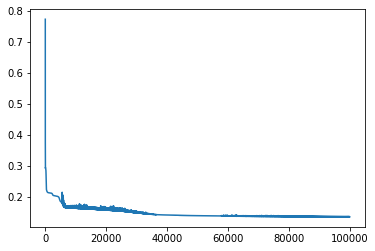

Teste Loss: 0.2458
Teste Cosine Similarity: 0.5903


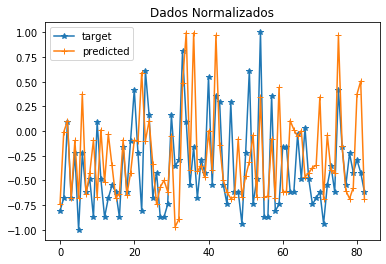

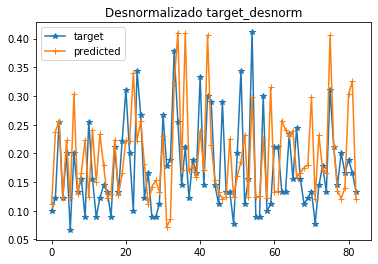

In [9]:
epoch = np.arange(0, epochs)
plt.plot(epoch,lossr)
plt.show()

# Transformando o dado de teste
X_test_scaled = scaler_x.fit_transform(X_test)
y_test_scaled = scaler_y.fit_transform(y_test)

# Avaliando a acurácia do modelo utilizando os dados de teste transformados
inputs = torch.autograd.Variable(torch.Tensor(X_test_scaled.astype(np.float32)).float())
targets = torch.autograd.Variable(torch.Tensor(y_test_scaled.astype(np.float32)).float())

optimizer.zero_grad()
out = net(inputs)
loss = criterion(out, targets)
loss.backward()
optimizer.step()

predicted = out.data

print('Teste Loss: %.4f' % (loss.item()))

# Implementando a métrica do Cosine Similarity
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
cos_sim = cos(targets, predicted)
print('Teste Cosine Similarity: %.4f' % (cos_sim.item()))

ninput = np.arange(len(X_test))
plt.figure()
plt.plot(ninput, y_test_scaled, '-*', label = 'target')
plt.plot(ninput, predicted.numpy(), '-+', label = 'predicted')
plt.title('Dados Normalizados')
plt.legend()
plt.show()

# Fazendo a transformação inversa para desnormalizar o dado de teste
predicted_desnorm = scaler_y.inverse_transform(predicted.numpy())
target_desnorm = scaler_y.inverse_transform(y_test_scaled)

plt.figure()
plt.plot(ninput, target_desnorm, '-*', label = 'target')
plt.plot(ninput, predicted_desnorm, '-+', label = 'predicted')
plt.title('Desnormalizado target_desnorm')
plt.legend()
plt.show()

D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


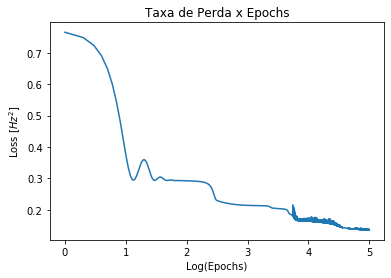

In [10]:
plt.figure()
plt.plot(np.log10(epoch),lossr)
plt.title("Taxa de Perda x Epochs")
plt.xlabel("Log(Epochs)")
plt.ylabel("Loss [$Hz^2$]")
plt.show()

## Pela análise dos gráficos, pode-se perceber que a rede atingiu dois níveis (valores extremos).
## Próximos passos:
- Mudar a função de ativação (tanh para relu)